### This notebook was used to convert the original CRED weights to SeisBench and ensure binary compatibility. It is not intended for further use, but only serves as a reference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seisbench.models import CRED
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import load_model
import scipy.signal

Using TensorFlow backend.


In [3]:
model = CRED(original_compatible=True)

In [4]:
tf_model = load_model("/home/munchmej/code/CRED/cred_original_outputs/final_model.h5")

In [5]:
tf_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 151, 41, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 76, 21, 8)    1952        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 76, 21, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 76, 21, 8)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [6]:
tf_state_dict = {x.name: x.numpy() for x in tf_model.weights}

In [7]:
for key, val in model.state_dict().items():
    print(key, tuple(val.shape))

conv1.weight (8, 3, 9, 9)
conv1.bias (8,)
cnn_block1.convs.0.weight (8, 8, 7, 7)
cnn_block1.convs.0.bias (8,)
cnn_block1.convs.1.weight (8, 8, 7, 7)
cnn_block1.convs.1.bias (8,)
cnn_block1.norms.0.weight (8,)
cnn_block1.norms.0.bias (8,)
cnn_block1.norms.0.running_mean (8,)
cnn_block1.norms.0.running_var (8,)
cnn_block1.norms.0.num_batches_tracked ()
cnn_block1.norms.1.weight (8,)
cnn_block1.norms.1.bias (8,)
cnn_block1.norms.1.running_mean (8,)
cnn_block1.norms.1.running_var (8,)
cnn_block1.norms.1.num_batches_tracked ()
conv2.weight (16, 8, 5, 5)
conv2.bias (16,)
cnn_block2.convs.0.weight (16, 16, 3, 3)
cnn_block2.convs.0.bias (16,)
cnn_block2.convs.1.weight (16, 16, 3, 3)
cnn_block2.convs.1.bias (16,)
cnn_block2.norms.0.weight (16,)
cnn_block2.norms.0.bias (16,)
cnn_block2.norms.0.running_mean (16,)
cnn_block2.norms.0.running_var (16,)
cnn_block2.norms.0.num_batches_tracked ()
cnn_block2.norms.1.weight (16,)
cnn_block2.norms.1.bias (16,)
cnn_block2.norms.1.running_mean (16,)
cnn_blo

In [8]:
for key, val in tf_state_dict.items():
    print(key, val.shape)

conv2d_1/kernel:0 (9, 9, 3, 8)
conv2d_1/bias:0 (8,)
batch_normalization_1/gamma:0 (8,)
batch_normalization_1/beta:0 (8,)
conv2d_2/kernel:0 (7, 7, 8, 8)
conv2d_2/bias:0 (8,)
batch_normalization_2/gamma:0 (8,)
batch_normalization_2/beta:0 (8,)
conv2d_3/kernel:0 (7, 7, 8, 8)
conv2d_3/bias:0 (8,)
conv2d_4/kernel:0 (5, 5, 8, 16)
conv2d_4/bias:0 (16,)
batch_normalization_3/gamma:0 (16,)
batch_normalization_3/beta:0 (16,)
conv2d_5/kernel:0 (3, 3, 16, 16)
conv2d_5/bias:0 (16,)
batch_normalization_4/gamma:0 (16,)
batch_normalization_4/beta:0 (16,)
conv2d_6/kernel:0 (3, 3, 16, 16)
conv2d_6/bias:0 (16,)
bidirectional_1/forward_lstm_1/kernel:0 (176, 256)
bidirectional_1/forward_lstm_1/recurrent_kernel:0 (64, 256)
bidirectional_1/forward_lstm_1/bias:0 (256,)
bidirectional_1/backward_lstm_1/kernel:0 (176, 256)
bidirectional_1/backward_lstm_1/recurrent_kernel:0 (64, 256)
bidirectional_1/backward_lstm_1/bias:0 (256,)
bidirectional_2/forward_lstm_2/kernel:0 (128, 256)
bidirectional_2/forward_lstm_2/rec

In [9]:
new_state_dict = {}

In [10]:
# Copy separate convs

# For input layer, resort channels from ENZ to ZNE
new_state_dict["conv1.weight"] = np.transpose(
    tf_state_dict["conv2d_1/kernel:0"], (3, 2, 0, 1)
)[:, [2, 1, 0]]
new_state_dict["conv1.bias"] = tf_state_dict["conv2d_1/bias:0"]

new_state_dict["conv2.weight"] = np.transpose(
    tf_state_dict["conv2d_4/kernel:0"], (3, 2, 0, 1)
)
new_state_dict["conv2.bias"] = tf_state_dict["conv2d_4/bias:0"]

In [11]:
# Copy CNN blocks

norm_dict = {
    "weight": "gamma",
    "bias": "beta",
    "running_mean": "moving_mean",
    "running_var": "moving_variance",
}

for i, cnn_block in enumerate([model.cnn_block1, model.cnn_block2]):
    for key in cnn_block.state_dict():
        layer, layer_id, t = key.split(".")

        layer_id = int(layer_id)

        if layer == "convs":
            source = f"conv2d_{2 + 3 * i + layer_id}"
            if t == "weight":
                data = np.transpose(tf_state_dict[f"{source}/kernel:0"], (3, 2, 0, 1))
            elif t == "bias":
                data = tf_state_dict[f"{source}/bias:0"]
        elif layer == "norms":
            if t == "num_batches_tracked":
                data = cnn_block.state_dict()[key]
            else:
                source = f"batch_normalization_{1 + 2 * i + layer_id}/{norm_dict[t]}:0"
                data = tf_state_dict[source]
        else:
            raise ValueError("Unknown layer")

        new_state_dict[f"cnn_block{i + 1}.{key}"] = data

In [12]:
# Copy LSTM block

for key in model.lstm_block.state_dict():
    _, layer_id, t = key.split(".")
    layer_id = int(layer_id)

    if t.endswith("reverse"):
        direction = "backward"
    else:
        direction = "forward"

    source = f"bidirectional_{1 + layer_id}/{direction}_lstm_{1 + layer_id}/"

    if t.startswith("weight_ih"):
        data = tf_state_dict[source + "kernel:0"].T
    elif t.startswith("weight_hh"):
        data = tf_state_dict[source + "recurrent_kernel:0"].T
    elif t.startswith("bias_hh"):
        data = 0.5 * tf_state_dict[source + "bias:0"]
    else:
        # bias_ih
        data = 0.5 * tf_state_dict[source + "bias:0"]

    new_state_dict[f"lstm_block.{key}"] = data

In [13]:
# Copy LSTM

for key in model.lstm.state_dict():
    source = "lstm_3/"
    t = key

    if t.startswith("weight_ih"):
        data = tf_state_dict[source + "kernel:0"].T
    elif t.startswith("weight_hh"):
        data = tf_state_dict[source + "recurrent_kernel:0"].T
    elif t.startswith("bias_hh"):
        data = 0.5 * tf_state_dict[source + "bias:0"]
    else:
        # bias_ih
        data = 0.5 * tf_state_dict[source + "bias:0"]

    new_state_dict[f"lstm.{key}"] = data

In [14]:
# Copy separate batch norms

for norm, org_source, i in [
    (model.norm1, "batch_normalization_5", 1),
    (model.norm2, "batch_normalization_6", 2),
]:
    for key in norm.state_dict():
        t = key
        if t == "num_batches_tracked":
            data = norm.state_dict()[key]
        else:
            source = f"{org_source}/{norm_dict[t]}:0"
            data = tf_state_dict[source]

        new_state_dict[f"norm{i}.{key}"] = data

In [15]:
# Copy dense layers

new_state_dict["fc1.weight"] = tf_state_dict["time_distributed_1/kernel:0"].T
new_state_dict["fc1.bias"] = tf_state_dict["time_distributed_1/bias:0"]

new_state_dict["fc2.weight"] = tf_state_dict["time_distributed_2/kernel:0"].T
new_state_dict["fc2.bias"] = tf_state_dict["time_distributed_2/bias:0"]

In [16]:
for key in new_state_dict.keys():
    if model.state_dict()[key].shape != new_state_dict[key].shape:
        print(key, model.state_dict()[key].shape, new_state_dict[key].shape)

In [17]:
assert len(new_state_dict) == len(model.state_dict())

In [18]:
for key in new_state_dict.keys():
    new_state_dict[key] = torch.tensor(new_state_dict[key])

/home/munchmej/anaconda3/envs/eqtransformer/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [19]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [31]:
torch.save(model.state_dict(), "/home/munchmej/.seisbench/models/cred/original.pt")

In [20]:
with h5py.File(
    "/home/munchmej/code/EQTransformer/ModelsAndSampleData/100samples.hdf5", "r"
) as f:
    wv = f["data"]["109C.TA_20060723155859_EV"][()]

wv -= np.mean(wv, axis=-1, keepdims=True)
wv /= np.amax(wv)
wv = wv.T

In [21]:
wv.shape

(3, 6000)

In [22]:
f, t, z = scipy.signal.stft(wv, fs=100, nperseg=80)
z = np.transpose(np.abs(z), (0, 2, 1))
z = z.reshape((1,) + z.shape)

In [23]:
z.shape

(1, 3, 151, 41)

In [24]:
# With a Keras function
get_all_layer_outputs = K.function(
    [tf_model.layers[0].input] + [K.learning_phase()],
    [l.output for l in tf_model.layers],
)

layer_output = get_all_layer_outputs(
    [np.transpose(z, (0, 2, 3, 1))] + [0]
)  # return the same thing
layer_names = [x.name for x in tf_model.layers]

In [25]:
layer_idx = 9
print(layer_names[layer_idx])

conv2d_4


In [26]:
model.eval()
with torch.no_grad():
    out = model(torch.tensor(z[:, [2, 1, 0]], dtype=torch.float32))
out = out.numpy()

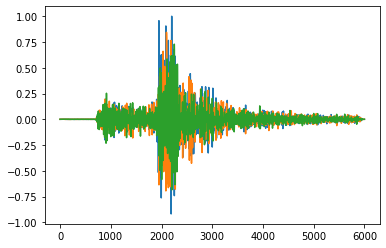

In [27]:
plt.plot(wv.T)

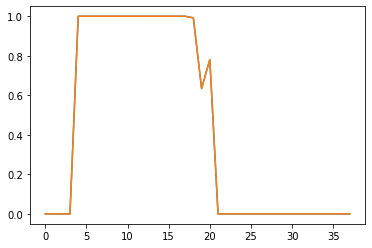

In [36]:
plt.plot(layer_output[-1][0, :, 0])
plt.plot(out[0, :, 0])

In [34]:
np.max(np.abs(layer_output[-1][0, :, 0] - out[0, :, 0]))

1.7881393e-07